In [2]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import sys
import Dataloader_patches
import Dataloader_slice_parts
import Dataloader_whole_slices
import Rotation_transform

/home/christoph/Dokumente/christoph-MA/MAenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_path = "/storage/Datensätze"
dataset = Dataloader_slice_parts.VolumeToSlicepartsDataset(root_dir=data_path,test=True,augmentation="tripath")

/storage/Datensätze/lung_test
/storage/Datensätze/lung_test/tom_2023-10-10-10-05-25_00.raw
/storage/Datensätze/lung_test/tom_2023-10-10-11-23-15_00.raw
/storage/Datensätze/skin_test
/storage/Datensätze/skin_test/tom_2024-01-26-10-40-06_00.raw
/storage/Datensätze/skin_test/tom_2024-03-29-10-41-00_00.raw
/storage/Datensätze/skin_test/tom_2024-01-25-17-52-24_00.raw
/storage/Datensätze/intestine_test
/storage/Datensätze/intestine_test/tom_2024-06-18-13-23-38_00.raw
/storage/Datensätze/intestine_test/tom_2023-08-30-14-36-45_00.raw


In [5]:
image, label = dataset.__getitem__(1714+1000)

image_untransformed, label = dataset.__getitem__(1000)

In [5]:
print(image_untransformed.shape)
transform = Rotation_transform.RandomRotate2D()

rotated_image = transform(image_untransformed)
print(rotated_image.shape)


torch.Size([3, 1755, 1755])


RuntimeError: Rotation dim1 out of range, dim1 = 3

In [7]:
count = 0
for i in range(int(dataset.__len__()/2)):

    image, label = dataset.__getitem__(dataset.__len__()//2+i)
    print(image.shape)
    image_untransformed, label = dataset.__getitem__(i)
    if image.equal(image_untransformed):
        print("equal")
        count += 1
print(count)


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([

KeyboardInterrupt: 

In [14]:
import torchio.transforms as tio

elastic_def = tio.RandomElasticDeformation(num_control_points=(5,9,9),locked_borders=2,max_displacement=(0,10,10))

In [29]:
image_rotated = Rotation_transform.RandomRotate2D()(image_untransformed)

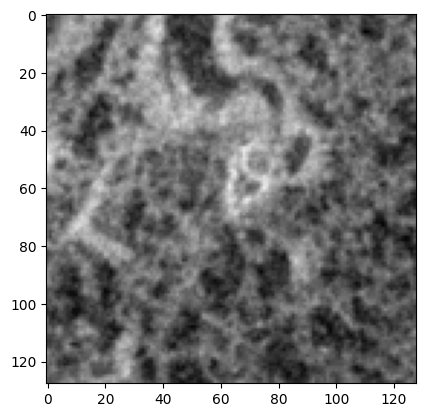

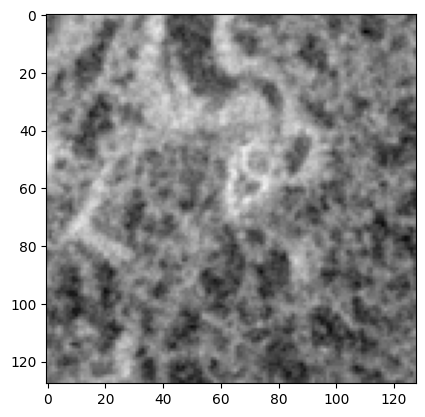

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image_untransformed[0,:,:], cmap='gray')
plt.show()
plt.imshow(image[0,:,:], cmap='gray')
plt.show()

In [2]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [7]:
model = SwinUNETR.swin_unetr_base(input_size=(128,128,32))

In [ ]:
model.swinViT.layers4[0].downsample.reduction = nn.Linear(3072,3)
model.swinViT.layers4[0].downsample.norm= nn.Identity(3,3)

In [22]:
print(model)

SwinUNETR_enc(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_fea

In [23]:
model.eval()
random_tensor = torch.randn(1,1,128, 128, 32)
print(random_tensor.shape)

outout = model(random_tensor)

torch.Size([1, 1, 128, 128, 32])


In [19]:
print(outout.shape)
print(outout[0])
import torch.nn.functional as F
print(F.softmax(outout[0], dim=0))  

torch.Size([1, 3])
tensor([ 0.6166,  0.4087, -1.0252], grad_fn=<SelectBackward0>)
tensor([0.4985, 0.4049, 0.0965], grad_fn=<SoftmaxBackward0>)


In [4]:
model = models.video.r3d_18()

In [21]:
model = models.video.swin3d_b(models.video.Swin3D_B_Weights.KINETICS400_V1)

/home/histo/Dokumente/christoph/Masterarbeit/Skripte_ML/MAvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [35]:
model.eval()

# Create a dummy input: (batch=1, channels=3, time=32, height=224, width=224)
dummy_input = torch.randn(1, 3, 1, 1)

# Run a forward pass to confirm it works
with torch.no_grad():
    output = model(dummy_input)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 1000])


In [43]:
m = nn.AdaptiveAvgPool2d((5, 7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)
# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(3)
input = torch.randn(1, 2, 2)
print(input)
output = m(input)
print(output.shape)
print(output)
# target output size of 10x7
m = nn.AdaptiveAvgPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)
print(output.shape)

torch.Size([1, 64, 5, 7])
tensor([[[-1.7920, -1.4982],
         [ 0.7260,  0.5807]]])
torch.Size([1, 3, 3])
tensor([[[-1.7920, -1.6451, -1.4982],
         [-0.5330, -0.4958, -0.4587],
         [ 0.7260,  0.6534,  0.5807]]])
torch.Size([1, 64, 10, 7])


In [1]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import video
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/christoph/Dokumente/christoph-MA/MA-Repo')
import Aggregator_Module
import Dataloader_patches_aggregator
from train import train_model
from eval import evaluate_model
from collections import OrderedDict

data_path = "/storage/Datensätze"

device = torch.device("cuda")

encoder = video.r3d_18(weights=video.R3D_18_Weights.KINETICS400_V1)


num_ftrs = encoder.fc.out_features

dropout = 0.5

decoder_enc = nn.Sequential(
                            nn.Linear(num_ftrs, 128),
                            nn.GELU(),
                            nn.Dropout(dropout)
                            )

model = Aggregator_Module.AttnMeanPoolMIL(gated=True, dropout=dropout, out_dim=3,encoder=decoder_enc,encoder_dim=128)

model.start_attention(freeze_encoder=False)


batch_size = 1

dataset = Dataloader_patches_aggregator.VolumeToFeaturesDataset(data_path, transform=None,num_channels=3, test=True,encoder=encoder)

train_set, val_set = torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)



/home/christoph/Dokumente/christoph-MA/MAenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing directory: /storage/Datensätze/lung_test
/storage/Datensätze/lung_test/tom_2023-10-10-10-05-25_00.raw
/storage/Datensätze/lung_test/tom_2023-10-10-11-23-15_00.raw
Processing directory: /storage/Datensätze/skin_test
/storage/Datensätze/skin_test/tom_2024-01-26-10-40-06_00.raw
/storage/Datensätze/skin_test/tom_2024-03-29-10-41-00_00.raw
/storage/Datensätze/skin_test/tom_2024-01-25-17-52-24_00.raw
Processing directory: /storage/Datensätze/intestine_test
/storage/Datensätze/intestine_test/tom_2024-06-18-13-23-38_00.raw
/storage/Datensätze/intestine_test/tom_2023-08-30-14-36-45_00.raw


In [4]:
encoder.to(device)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [14]:
features,labels,patches = dataset.__getitem__(0)
print(features.shape)
print(len(patches))
print(labels)

torch.Size([10, 400])
10
tensor(0)


In [29]:
import torch.nn.functional as F
model = model.to(device)

with torch.no_grad:
    output = model(features.unsqueeze(0))
print((output))

TypeError: 'type' object does not support the context manager protocol

In [25]:
_, preds = torch.max(output, 1)

In [27]:
preds.item()

0

In [9]:
for patch in patches:
    print(patch.shape)

(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)
(128, 128, 32)


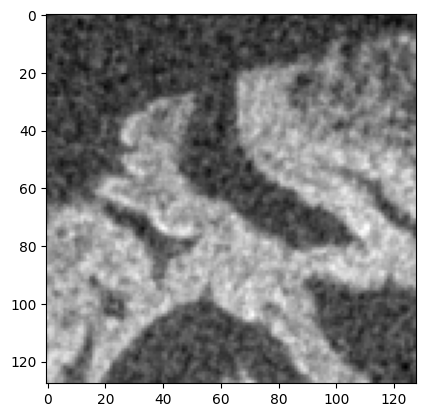

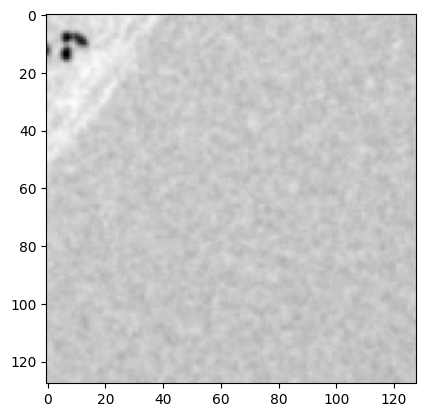

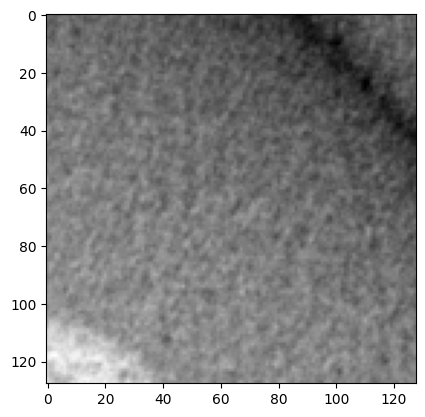

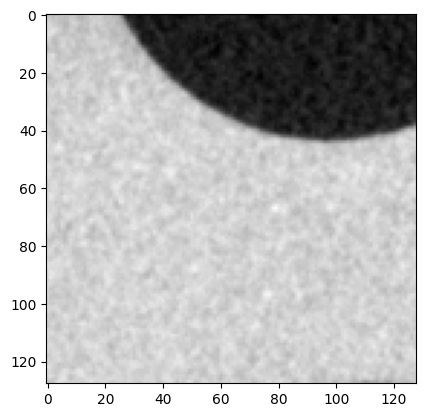

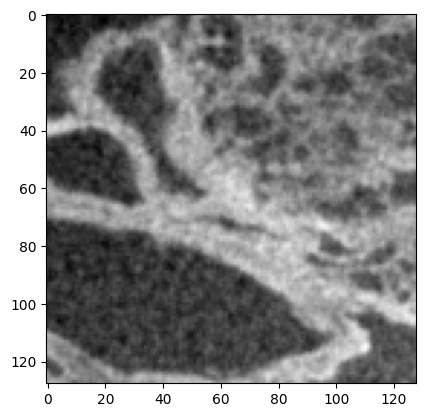

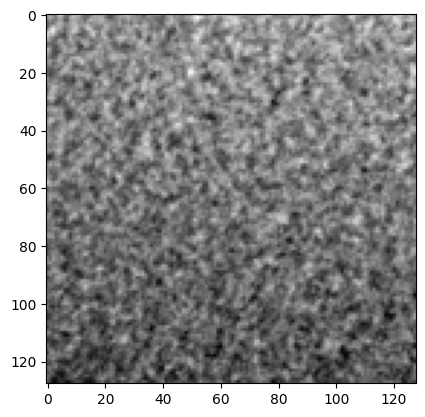

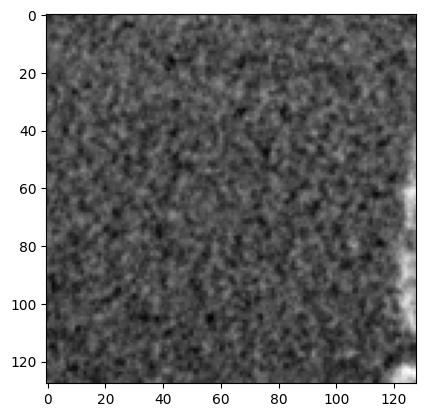

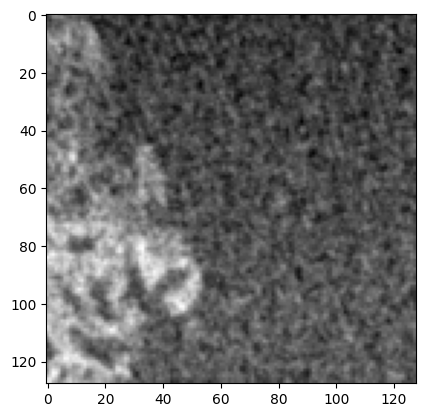

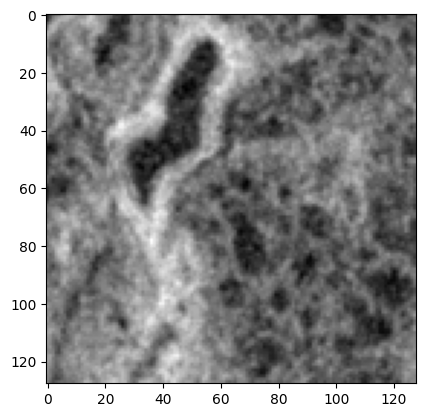

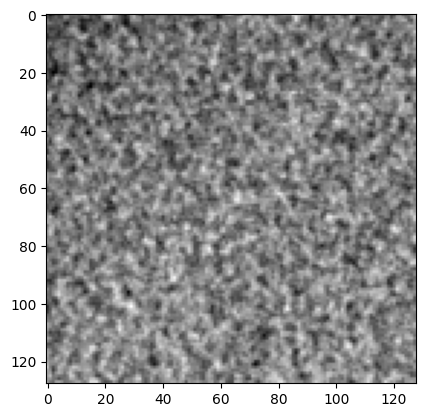

In [30]:
import matplotlib.pyplot as plt
for patch in patches:
    plt.imshow(patch[:,:,30], cmap='gray')
    plt.show()

In [5]:
tensor = torch.randn(10,3,128,128,32)

In [11]:
input = torch.tensor1,tensor

TypeError: tensor() takes 1 positional argument but 2 were given

In [6]:
out =  aggregator_model(tensor)

ValueError: not enough values to unpack (expected 3, got 2)